# 03_Modeling

https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

## Imports

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import average_precision_score, adjusted_rand_score, roc_auc_score, average_precision_score, silhouette_score
import hdbscan
import umap
import joblib  
from visualization import compare_hdbscan_params, plot_metrics_comparison
import plotly.express as px

## Load data

In [44]:
df = pd.read_csv('../data/processed/windowed_dataset_cleaned.csv')
X = df[df.columns.difference(['is_attack'])]  # Features
y = df['is_attack']  # Labels

## HDBSCAN

### Selecting hyperparameters

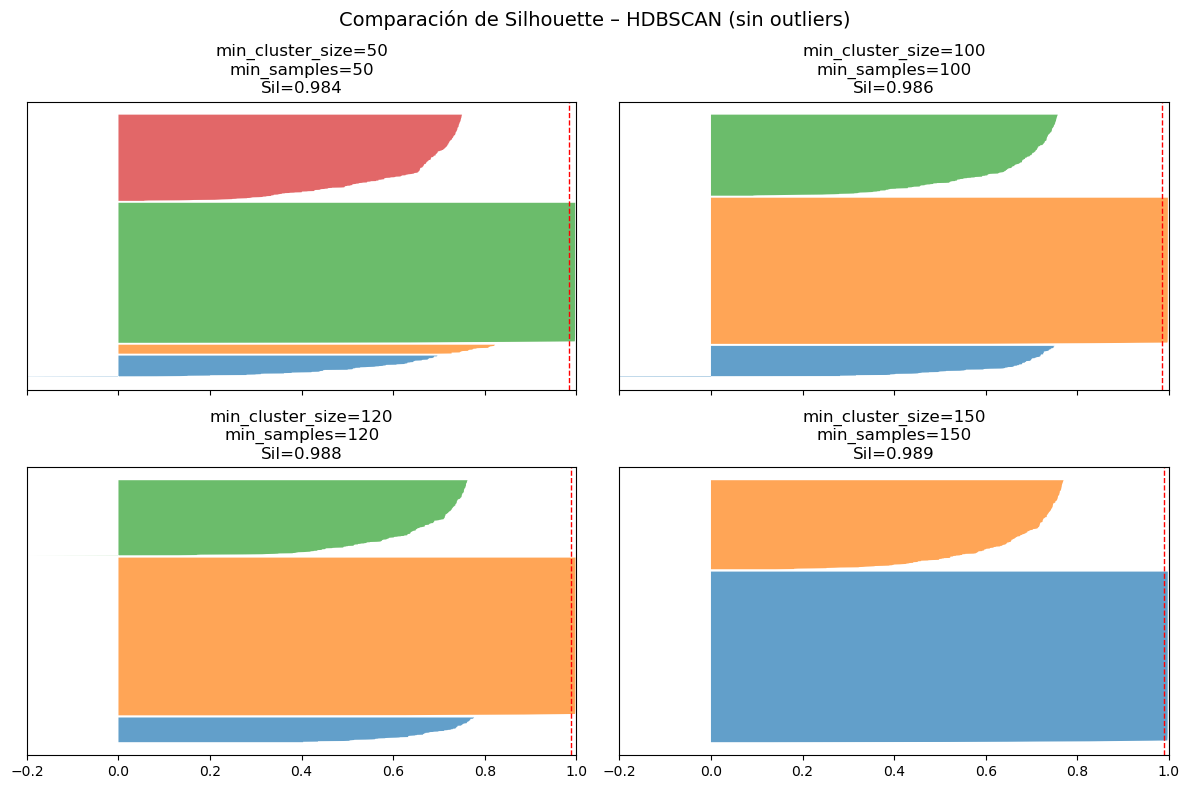

In [45]:
param_grid = [
    (50, 50),
    (100, 100),
    (120, 120),
    (150, 150),
]

# Ejecuta la comparación CON etiquetas verdaderas
results, fig1 = compare_hdbscan_params(
    X, 
    param_grid,
    y_true=y,  # <-- Pasa las etiquetas verdaderas aquí
    n_cols=2
)

plt.show()

- The main 2 parameters in HDBSCAN are **min_cluster_size** and **min_samples**. There are also parametros like **alpha**, but it is considered better not to mess around with this parameter. With these 2 parameters we can influence the number and size of the clusters. 
- **min_cluster_size** is the minimum number of points a cluster needs to be considered a cluster. We know other data and do not want many small clusters, so we will keep it higher than 50. **min_samples** tells how conservative the model is going to be. The more conservative it is, the more samples is going to cluster as outliers.
- **min_cluster_size = min_samples** is the way to go for outlier detection with HDBSCAN as we make dense clusters only and the rest are considered outliers.

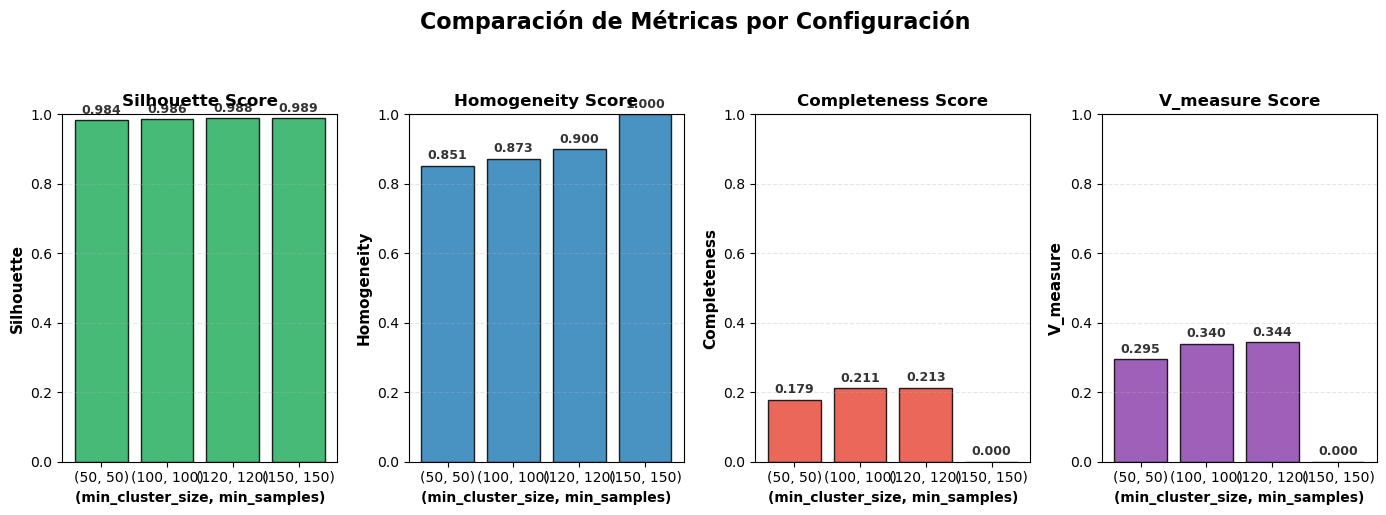

In [46]:
fig2 = plot_metrics_comparison(results)
plt.show()

- When selecting the best hyperparameteres, we look for the ones that make correct clustering. If we look at the Silhouette visuals, we don't want a clustering split which has samples with negative Silhouette scores. that would mean that some samples are closer to the closest cluster that to their own one.
- Semi supervised approach: We also look for the ones that have the classes correctly distributed between clusters. Ideally every sample of the same class should be in the same cluster (completeness) and no sample of the other classes should be sharing that same cluster (homogeneity).
- Here, **min_cluster_size = min_samples = 120** matches every requirement

### Fitting the model

In [47]:
# -----------------------------
# HDBSCAN clustering
# -----------------------------
hdb = hdbscan.HDBSCAN(
    min_cluster_size=120,#Se recomienda igualar min_samples a min_cluster_size para outlier detection
    min_samples=120, # bajarlo significa tomar mas riesgo y clusterizar mas puntos, subirlo significa ser mas conservador y detectar mas outliers
    cluster_selection_method='eom', # 'leaf' or 'eom' EXCESS of Mass para clusters más grandes y estables
    metric='euclidean'
)
hdb_labels = hdb.fit_predict(X)
print("HDBSCAN clusters:", np.unique(hdb_labels))

HDBSCAN clusters: [-1  0  1  2]


### Visualizing the results: PCA & UMAP

In [48]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

print("Varianza explicada por componente:")
print(pca.explained_variance_ratio_)
print("Varianza total explicada:", pca.explained_variance_ratio_.sum())

df_pca = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'HDBSCAN_cluster': hdb_labels.astype(str),
    'is_attack': y
})

fig = px.scatter(
    df_pca,
    x='PCA1',
    y='PCA2',
    color='HDBSCAN_cluster',
    title="PCA (2D) – HDBSCAN clusters",
    width=900,
    hover_data=['is_attack'],
    height=700
)

fig.update_traces(marker=dict(size=6, opacity=0.8))
fig.update_layout(legend_title_text='HDBSCAN Cluster')

fig.show()


Varianza explicada por componente:
[0.55767155 0.43215243]
Varianza total explicada: 0.989823983890221


In [49]:
# -----------------------------
# UMAP embedding
# -----------------------------
reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)

X_umap = reducer.fit_transform(X)

df_vis = df.copy()
df_vis['UMAP1'] = X_umap[:, 0]
df_vis['UMAP2'] = X_umap[:, 1]
df_vis['cluster_label'] = hdb_labels

df_vis['Cluster'] = df_vis['cluster_label'].map(
    lambda lbl: 'Outlier' if lbl == -1 else f'Cluster {lbl}'
)

cluster_order = ['Outlier'] + [f'Cluster {i}' for i in sorted(df_vis[df_vis['cluster_label'] != -1]['cluster_label'].unique())]
df_vis['Cluster'] = pd.Categorical(df_vis['Cluster'], categories=cluster_order, ordered=True)

hover_cols = ['is_attack', 'n_connections'] 

fig = px.scatter(
    df_vis,
    x='UMAP1',
    y='UMAP2',
    color='Cluster',
    hover_data=hover_cols,  # Ahora sí: columnas del DataFrame
    title="UMAP + HDBSCAN clusters",
    width=900,
    height=700
)

fig.update_traces(marker=dict(size=6, opacity=0.8))
fig.update_layout(legend_title_text='HDBSCAN Clusters')
fig.write_image(
    "../reports/figures/umap_hdbscan_210.png",
    width=1000,      # ancho en píxeles
    height=600,      # alto en píxeles
    scale=2          # factor de escalado (2 = ~200 DPI)
)
fig.show()

/Users/taxi/miniconda3/envs/consoning/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Users/taxi/miniconda3/envs/consoning/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:324: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



- The model sees a big central cluster and 3 smaller islands that look like curves.
- As the attacks are very close to some network traffic instances the model mixes them together in the cluster 0 and outliers. (zoom bottom right corner). The HDBSCAN algorithm is based on densities. The samples in the bottom right corner are very close to eachother so that might complicate the task of clustering via densities. Making the difference for the model become a very difficult task.
- The model also sees some outliers in the top small island.

In [50]:
pd.crosstab(df['is_attack'], hdb_labels)

col_0,-1,0,1,2
is_attack,,,,
0.0,1195,26,22056,382
1.0,246,100,0,0


- The outlier management is better than with GMM but the model is not able to isolate every attack as outlier or as a cluster.
- A dedicated model for outlir detection should be used for this type of problem.

## Save model

In [51]:
joblib.dump(hdb, "../models/hdbscan_model.joblib")

['../models/hdbscan_model.joblib']